In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
ROOT_PATH = "/content/drive/MyDrive/speed-prediction/"
print(os.listdir(ROOT_PATH))

['README.md', 'val_loss.png', 'model.png', 'data', '.git', 'requirements.txt', 'labels.txt', 'images', 'Dashcam Speed - C3D.ipynb']


In [4]:
import sys
sys.path.append(ROOT_PATH)

In [5]:
requirements = ROOT_PATH + "/requirements.txt"
%pip install -r {requirements}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import cv2
import os
import time
import numpy as np
import h5py
import os, random
import matplotlib.pylab as plt
import keras.utils.vis_utils as vutil
from skimage.transform import resize
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from keras.optimizers import SGD, Adam, RMSprop
from imgaug import augmenters as iaa
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D, Conv2DTranspose, ZeroPadding2D, Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, add, LSTM, TimeDistributed, concatenate
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import conv_utils
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
import numpy as np
from keras.layers import LSTM
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
import sys
from PIL import Image

%matplotlib inline

In [7]:
def show(image, cmap='gray', ax=None):
    if ax is None:
        plt.figure()
    
    plt.imshow(image[:,:,::-1].astype('uint8'), cmap=cmap)

In [8]:
FRAME_H, FRAME_W = 112, 112
TIMESTEPS = 16

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Code up the generators

A short snippet to create training set and validation set from the given video data.

In [9]:
"""ORIGINAL"""
"""video_file = 'train'

video_inp = 'data/' + video_file + '.mp4'
label_inp = open('data/' + video_file + '.txt').readlines()

video_reader = cv2.VideoCapture(video_inp)
train_image = 'data/' + video_file + '/images/'
train_label = open('data/' + video_file + '/labels.txt', 'w')

counter = 0

while(True):
    ret, frame = video_reader.read()

    if ret == True:
        cv2.imwrite(train_image + str(counter).zfill(6) + '.png', frame)
        train_label.write(label_inp[counter])
        counter += 1
    else:
        break

video_reader.release()
train_label.close()"""

"video_file = 'train'\n\nvideo_inp = 'data/' + video_file + '.mp4'\nlabel_inp = open('data/' + video_file + '.txt').readlines()\n\nvideo_reader = cv2.VideoCapture(video_inp)\ntrain_image = 'data/' + video_file + '/images/'\ntrain_label = open('data/' + video_file + '/labels.txt', 'w')\n\ncounter = 0\n\nwhile(True):\n    ret, frame = video_reader.read()\n\n    if ret == True:\n        cv2.imwrite(train_image + str(counter).zfill(6) + '.png', frame)\n        train_label.write(label_inp[counter])\n        counter += 1\n    else:\n        break\n\nvideo_reader.release()\ntrain_label.close()"

In [10]:
""" Creating image with labels from video on own computer (ANACONDA)
label_inp = open("./data/train.txt").readlines()

video_reader = cv2.VideoCapture("./data/train.mp4")
train_image = './data/images/'
train_label = open('./data/labels.txt', 'w')

counter = 0

while(True):
    ret, frame = video_reader.read()

    if ret == True:
        cv2.imwrite(train_image + str(counter).zfill(6) + '.png', frame)
        train_label.write(label_inp[counter])
        counter += 1
    else:
        break

video_reader.release()
train_label.close()
"""


' Creating image with labels from video on own computer (ANACONDA)\nlabel_inp = open("./data/train.txt").readlines()\n\nvideo_reader = cv2.VideoCapture("./data/train.mp4")\ntrain_image = \'./data/images/\'\ntrain_label = open(\'./data/labels.txt\', \'w\')\n\ncounter = 0\n\nwhile(True):\n    ret, frame = video_reader.read()\n\n    if ret == True:\n        cv2.imwrite(train_image + str(counter).zfill(6) + \'.png\', frame)\n        train_label.write(label_inp[counter])\n        counter += 1\n    else:\n        break\n\nvideo_reader.release()\ntrain_label.close()\n'

These are a set of functions to add disturtances to the images used during the training process.

In [9]:
sometime = lambda aug: iaa.Sometimes(0.3, aug) #randomly apply some of the augmentations with a prob of 0.3
sequence = iaa.Sequential([ #sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            #sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            #sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            sometime(iaa.CoarseDropout((0.0, 0.1), size_percent=(0.01, 0.02), per_channel=0.2)),
                            #sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def normalize(image):
    return image - [104.00699, 116.66877, 122.67892] #image - [mean pixel values]

def augment(image, flip, bright_factor):
    # random disturbances borrowed from IAA
    image = sequence.augment_image(image)
    
    # random brightness change
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    # random flip (vertical axis)
    if flip:
        image = cv2.flip(image, 1)
                
    return image

This is the class to generate batches for both training and validation.

In [11]:
class BatchGenerator:
    def __init__(self, file_path, indices, batch_size, timesteps=1, shuffle=True, jitter = True, norm=True, overlap=False):
        self.file_path  = file_path
        self.batch_size = batch_size
        self.timesteps  = timesteps
        
        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.images = sorted(os.listdir(self.file_path + 'images/'))
        self.labels = open(self.file_path + 'labels.txt').readlines()
        
        self.indices = indices

    def get_gen(self):
        num_img = len(self.indices)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    
        
        if self.shuffle: np.random.shuffle(list(self.indices))# Convert range object to list

        while True:
            if l_bound == r_bound:
                l_bound = 0
                r_bound = self.batch_size if self.batch_size < num_img else num_img
                
                if self.shuffle: np.random.shuffle(list(self.indices))

            # the arrays which hold in the inputs and outputs
            x_batch = np.zeros((r_bound - l_bound, self.timesteps, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))
            currt_inst = 0        

            for index in self.indices[l_bound:r_bound]:
                #if index > 2*self.timesteps:
                #    index -= np.random.randint(0, self.timesteps)
                
                # construct each input
                flip = (np.random.random() > 0.5)
                bright_factor = 0.5 + np.random.uniform() * 0.5
                
                for i in range(self.timesteps):
                    image = cv2.imread(self.file_path + 'images/' + self.images[index-self.timesteps+1+i])
                    heigh = image.shape[0]
                    image = image[np.concatenate([np.arange(int(heigh/3)), np.arange(int(heigh*2/3),heigh)]),:,:]
                    image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
                    
                    if self.jitter: image = augment(image, flip, bright_factor)
                    if self.norm:   image = normalize(image)                    
                    
                    x_batch[currt_inst, i] = image

                # construct each output
                speeds = [float(speed) for speed in self.labels[index-self.timesteps+1:index+1]]
                y_batch[currt_inst] = np.mean(speeds)

                currt_inst += 1
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.indices)/self.batch_size 

Perform some visualization to make sure that the generated batches make sense.

In [12]:


indices = range(TIMESTEPS-1, len(os.listdir(ROOT_PATH  + 'images/')), TIMESTEPS)
gen_train = BatchGenerator(ROOT_PATH, indices, batch_size=4, timesteps=TIMESTEPS)
generator = gen_train.get_gen()

In [13]:
len(os.listdir(ROOT_PATH  + 'images/')) # number of images 

11231

In [14]:
gen_train.get_size()

175.25

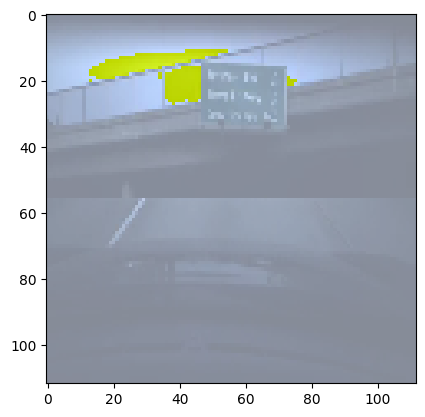

In [16]:
show(next(generator)[0][0][0])

# Construct the model

In [17]:
model = Sequential()
input_shape=(TIMESTEPS, FRAME_H, FRAME_W, 3) # l, h, w, c

# 1st layer group
model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))

# 2nd layer group
model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))

# 3rd layer group
model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))

# 4th layer group
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

# 5th layer group
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))
model.add(Flatten())

# FC layers group
model.add(Dense(4096, activation='relu', name='fc6'))
model.add(Dropout(.5))
model.add(Dense(4096, activation='relu', name='fc7'))
model.add(Dropout(.5))
model.add(Dense(1,    activation='linear', name='fc8'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64)  5248      
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                                 
 pool3 (MaxPooling3D)        (None, 4, 14, 14, 256)    0

# Load weights pretrained on the Sports-1M dataset

In [34]:
sports_1m = h5py.File(ROOT_PATH + '/data/c3d-sports1M_weights.h5', mode='r')

for i in range(len(model.layers)):
    layer = model.layers[i]
    layer_name = 'layer_' + str(i)
    
    weights = sports_1m[layer_name].values()
    # print([np.array(weight) for j, weight in enumerate(weights)])
    weights = [np.array(weight) for weight in weights] # original weights = [weight.value for weight in weights]
    weights = [weight if len(weight.shape) < 4 else weight.transpose(2,3,4,1,0) for weight in weights]
    
    layer.set_weights(weights)
    
    # ignore the last 2 layer, 1 dropout and 1 dense
    if i > len(model.layers) - 3:
        break

# Train the network

In [24]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint(ROOT_PATH + '/data/c3d-sports1M_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq=1)


split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir(ROOT_PATH + 'images/')), TIMESTEPS)
np.random.shuffle(list(indices))

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator(ROOT_PATH, train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator(ROOT_PATH, valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [25]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [33]:
#model.load_weights(ROOT_PATH + '/data/c3d-sports1M_weights.h5')

ValueError: ignored

In [ ]:
#tb_counter  = max([int(num) for num in os.listdir('../logs/speed/')] or [0]) + 1
#tensorboard = TensorBoard(log_dir='../logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#model.compile(loss=custom_loss, optimizer=sgd)
from tensorflow.keras.optimizers import AdamW

adam = AdamW(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss=custom_loss, optimizer=adam)

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 5, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint], #callbacks = [early_stop, checkpoint, tensorboard], 
                    max_queue_size = 8)

<ipython-input-42-68261a329c22>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = gen_train.get_gen(),


Epoch 1/5


  1/157 [..............................] - ETA: 1:34:07 - loss: 211.8024

  2/157 [..............................] - ETA: 1:27:46 - loss: 111.3111

  3/157 [..............................] - ETA: 1:25:44 - loss: 78.2840 

  4/157 [..............................] - ETA: 1:24:13 - loss: 59.7552

  5/157 [..............................] - ETA: 1:24:58 - loss: 54.5877

  6/157 [>.............................] - ETA: 1:23:57 - loss: 46.5460

  7/157 [>.............................] - ETA: 1:23:11 - loss: 40.4951

  8/157 [>.............................] - ETA: 1:22:47 - loss: 36.0396

  9/157 [>.............................] - ETA: 1:22:02 - loss: 42.9103

 10/157 [>.............................] - ETA: 1:21:12 - loss: 39.3966

 11/157 [=>............................] - ETA: 1:22:25 - loss: 38.0248

 12/157 [=>............................] - ETA: 1:21:43 - loss: 38.8165

 13/157 [=>............................] - ETA: 1:21:07 - loss: 39.5395

 14/157 [=>............................] - ETA: 1:21:27 - loss: 37.4114

 15/157 [=>............................] - ETA: 1:20:53 - loss: 36.8917

 16/157 [==>...........................] - ETA: 1:20:35 - loss: 36.8025

 17/157 [==>...........................] - ETA: 1:20:13 - loss: 35.3353

 18/157 [==>...........................] - ETA: 1:19:38 - loss: 33.6243

 19/157 [==>...........................] - ETA: 1:19:14 - loss: 31.9791

 20/157 [==>...........................] - ETA: 1:18:39 - loss: 30.6110

 21/157 [===>..........................] - ETA: 1:18:08 - loss: 29.3440

 22/157 [===>..........................] - ETA: 1:17:41 - loss: 28.0385

 23/157 [===>..........................] - ETA: 1:17:11 - loss: 27.6110

 24/157 [===>..........................] - ETA: 1:16:50 - loss: 26.8235

 25/157 [===>..........................] - ETA: 1:16:15 - loss: 25.8538

 26/157 [===>..........................] - ETA: 1:15:39 - loss: 25.0696

 27/157 [====>.........................] - ETA: 1:15:11 - loss: 24.3185

 28/157 [====>.........................] - ETA: 1:14:38 - loss: 23.5094

 29/157 [====>.........................] - ETA: 1:14:08 - loss: 23.1387

 30/157 [====>.........................] - ETA: 1:13:34 - loss: 22.4260

 31/157 [====>.........................] - ETA: 1:13:02 - loss: 22.0228

 32/157 [=====>........................] - ETA: 1:12:33 - loss: 21.6272

 33/157 [=====>........................] - ETA: 1:12:00 - loss: 21.0630

 34/157 [=====>........................] - ETA: 1:11:27 - loss: 20.6997

 35/157 [=====>........................] - ETA: 1:10:57 - loss: 20.6690

 36/157 [=====>........................] - ETA: 1:10:24 - loss: 20.2632

 37/157 [======>.......................] - ETA: 1:09:56 - loss: 19.7840

 38/157 [======>.......................] - ETA: 1:09:22 - loss: 19.3669

 39/157 [======>.......................] - ETA: 1:08:45 - loss: 19.4059

 40/157 [======>.......................] - ETA: 1:08:15 - loss: 18.9749

 41/157 [======>.......................] - ETA: 1:07:41 - loss: 18.7902

 42/157 [=======>......................] - ETA: 1:07:09 - loss: 18.5677

 43/157 [=======>......................] - ETA: 1:06:34 - loss: 18.2010

 44/157 [=======>......................] - ETA: 1:05:58 - loss: 18.2214

 45/157 [=======>......................] - ETA: 1:05:26 - loss: 17.9251

 46/157 [=======>......................] - ETA: 1:04:50 - loss: 17.6532

 47/157 [=======>......................] - ETA: 1:04:12 - loss: 18.1025

 48/157 [========>.....................] - ETA: 1:03:40 - loss: 18.0402

 49/157 [========>.....................] - ETA: 1:03:04 - loss: 17.7259

 50/157 [========>.....................] - ETA: 1:02:27 - loss: 17.6634

 51/157 [========>.....................] - ETA: 1:01:54 - loss: 17.7848

 52/157 [========>.....................] - ETA: 1:01:18 - loss: 17.5014

 53/157 [=========>....................] - ETA: 1:00:44 - loss: 17.2155

 54/157 [=========>....................] - ETA: 1:00:09 - loss: 17.0142

 55/157 [=========>....................] - ETA: 59:34 - loss: 16.8479  

 56/157 [=========>....................] - ETA: 59:01 - loss: 16.6106

 57/157 [=========>....................] - ETA: 58:26 - loss: 16.3344

 58/157 [==========>...................] - ETA: 57:49 - loss: 16.1348

 59/157 [==========>...................] - ETA: 57:16 - loss: 15.8956

 60/157 [==========>...................] - ETA: 56:40 - loss: 15.6629

 61/157 [==========>...................] - ETA: 56:04 - loss: 15.4262

 62/157 [==========>...................] - ETA: 55:31 - loss: 15.2655

 63/157 [===========>..................] - ETA: 54:57 - loss: 15.0727

 64/157 [===========>..................] - ETA: 54:23 - loss: 14.8759

 65/157 [===========>..................] - ETA: 53:49 - loss: 14.6645

 66/157 [===========>..................] - ETA: 53:13 - loss: 14.5561

 67/157 [===========>..................] - ETA: 52:40 - loss: 14.4103

 68/157 [===========>..................] - ETA: 52:04 - loss: 14.2078

 69/157 [============>.................] - ETA: 51:28 - loss: 14.0077

 70/157 [============>.................] - ETA: 50:55 - loss: 13.8186

 71/157 [============>.................] - ETA: 50:19 - loss: 13.6649

 72/157 [============>.................] - ETA: 49:45 - loss: 13.5365

 73/157 [============>.................] - ETA: 49:10 - loss: 13.3817

 74/157 [=============>................] - ETA: 48:35 - loss: 13.2089

 75/157 [=============>................] - ETA: 48:01 - loss: 13.1084

 76/157 [=============>................] - ETA: 47:25 - loss: 13.0154

 77/157 [=============>................] - ETA: 46:50 - loss: 12.8562

 78/157 [=============>................] - ETA: 46:16 - loss: 12.7354

 79/157 [==============>...............] - ETA: 45:45 - loss: 12.6340

 80/157 [==============>...............] - ETA: 45:11 - loss: 12.5051

 81/157 [==============>...............] - ETA: 44:35 - loss: 12.3538

 82/157 [==============>...............] - ETA: 44:01 - loss: 12.2474

 83/157 [==============>...............] - ETA: 43:26 - loss: 12.1805

 84/157 [===============>..............] - ETA: 42:51 - loss: 12.0516

 85/157 [===============>..............] - ETA: 42:16 - loss: 11.9239

 86/157 [===============>..............] - ETA: 41:41 - loss: 11.8490

 87/157 [===============>..............] - ETA: 41:06 - loss: 11.8797

 88/157 [===============>..............] - ETA: 40:32 - loss: 11.7526

 89/157 [===============>..............] - ETA: 39:56 - loss: 11.7566

 90/157 [================>.............] - ETA: 39:20 - loss: 11.6321

 91/157 [================>.............] - ETA: 38:46 - loss: 11.5333

 92/157 [================>.............] - ETA: 38:10 - loss: 11.5375

 93/157 [================>.............] - ETA: 37:35 - loss: 11.5416

 94/157 [================>.............] - ETA: 37:00 - loss: 11.5897

 95/157 [=================>............] - ETA: 36:25 - loss: 11.4826

 96/157 [=================>............] - ETA: 35:49 - loss: 11.5492

 97/157 [=================>............] - ETA: 35:15 - loss: 11.6918

 98/157 [=================>............] - ETA: 34:40 - loss: 11.6868

 99/157 [=================>............] - ETA: 34:05 - loss: 11.5760

100/157 [==================>...........] - ETA: 33:30 - loss: 11.5212

101/157 [==================>...........] - ETA: 32:55 - loss: 11.4535

102/157 [==================>...........] - ETA: 32:20 - loss: 11.3635

103/157 [==================>...........] - ETA: 31:45 - loss: 11.2999

104/157 [==================>...........] - ETA: 31:09 - loss: 11.2705

105/157 [===================>..........] - ETA: 30:35 - loss: 11.1794

106/157 [===================>..........] - ETA: 30:00 - loss: 11.2547

107/157 [===================>..........] - ETA: 29:25 - loss: 11.4540

108/157 [===================>..........] - ETA: 28:50 - loss: 11.3491

109/157 [===================>..........] - ETA: 28:15 - loss: 11.2841

110/157 [===================>..........] - ETA: 27:40 - loss: 11.2829

111/157 [====================>.........] - ETA: 27:05 - loss: 11.1929

112/157 [====================>.........] - ETA: 26:30 - loss: 11.1203

113/157 [====================>.........] - ETA: 25:55 - loss: 11.0685

114/157 [====================>.........] - ETA: 25:20 - loss: 11.0013

115/157 [====================>.........] - ETA: 24:45 - loss: 10.9142

116/157 [=====================>........] - ETA: 24:10 - loss: 10.8628

117/157 [=====================>........] - ETA: 23:35 - loss: 10.8055

118/157 [=====================>........] - ETA: 23:00 - loss: 10.7591

119/157 [=====================>........] - ETA: 22:25 - loss: 10.7129

120/157 [=====================>........] - ETA: 21:50 - loss: 10.6578

121/157 [======================>.......] - ETA: 21:15 - loss: 10.5781

122/157 [======================>.......] - ETA: 20:40 - loss: 10.5026

123/157 [======================>.......] - ETA: 20:05 - loss: 10.4186

124/157 [======================>.......] - ETA: 19:30 - loss: 10.3514

125/157 [======================>.......] - ETA: 18:55 - loss: 10.2873

126/157 [=======================>......] - ETA: 18:20 - loss: 10.2077

127/157 [=======================>......] - ETA: 17:45 - loss: 10.2092

128/157 [=======================>......] - ETA: 17:10 - loss: 10.2088

# Analyze the trained network

In [ ]:
file_name = 'udacity' # name without extension of arbitrary dashcam video

video_inp = 'data/' + file_name + '.mp4'
video_out = 'data/' + file_name + '_out.mp4'
label_inp = open('data/' + file_name + '.txt', 'r').readlines() if os.path.exists('data/' + file_name + '.txt') else None
label_out = open('data/' + file_name + '_pred.txt', 'w')

video_reader = cv2.VideoCapture(video_inp)
h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (w, h))

x_batch_original = np.zeros((TIMESTEPS, h, w, 3))
x_batch = np.zeros((1, TIMESTEPS, FRAME_H, FRAME_W, 3))
frame_counter = 0
frame_counter_all = 0
curr_speed = 0.
acc_error = 0

while(True):
    ret, image = video_reader.read()

    if ret == True:
        if frame_counter_all > -1: # only start processing from certain frame count
            x_batch_original[frame_counter] = image

            heigh = image.shape[0]
            image = image[np.concatenate([np.arange(heigh/3), np.arange(heigh*2/3,heigh)]),:,:]
            image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
            image = normalize(image)

            x_batch[0, frame_counter] = image

            if frame_counter == TIMESTEPS - 1:
                curr_speed = model.predict(x_batch)[0][0]
                frame_counter = -1

                for i in range(TIMESTEPS):
                    image = x_batch_original[i]
                    caption = 'Speed (Predicted): ' + str("{0:.2f}".format(curr_speed))
                    image = cv2.putText(image, caption, (5,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

                    # write true speed if available
                    if label_inp is not None:
                        true_speed = float(label_inp[frame_counter_all-(TIMESTEPS-1)+i].strip())
                        caption = 'Speed (Actual): ' + str("{0:.2f}".format(true_speed))
                        image = cv2.putText(image, caption, (5,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3)
                        
                        acc_error += (curr_speed - true_speed) ** 2
                        caption = 'MSE: ' + str("{0:.2f}".format(acc_error/(frame_counter_all-TIMESTEPS+1+i+1)))
                        image = cv2.putText(image, caption, (5,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)                        

                    video_writer.write(np.uint8(image))
                    label_out.write(str(curr_speed) + '\n')

            frame_counter += 1
    else:
        break
    
    frame_counter_all += 1

video_reader.release()
video_writer.release()

label_out.close()

FileNotFoundError: ignored

# Test code

In [ ]:
video_out = ROOT_PATH + '/data/test.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (640, 480))

labels = open(ROOT_PATH + '/data/test_pred.txt', 'w')

with open('data/output/interpolated.csv', 'r') as csvfile:
    print (csvfile.readline())
    
    for row in csvfile:
        if 'center' in row:
            row = row.split(',')

            image = cv2.imread('data/output/' + row[5])
            
            video_writer.write(np.uint8(image))
            #labels.write(row[8] + '\n')
            labels.write(str(float(row[8])*0.621371) + '\n')
            
video_writer.release()
labels.close()

In [ ]:
indices = range(16, len(os.listdir('data/udacity/images/')), 16)
np.random.shuffle(indices)

train_indices = indices[0:int(len(indices)*0.8)]
valid_indices = indices[int(len(indices)*0.8):]